In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.0.dev2151-g2a716
Compiled: Dec 23 2014 21:10:53



In [2]:
dwiScan='/Shared/johnsonhj/TrackOn/Experiments/20140203_DWIProcessing/VISUALLY_INSPECTED/HDNI_001/249903245/249903245_20110719_30/249903245_249903245_20110719_30_DWI_CONCAT_QCed_INSPECTED.nrrd'
t2Scan='/Shared/sinapse/CACHE/20141124_TrackOn_base_Results/HDNI_001/249903245/249903245_20110719_30/TissueClassify/t2_average_BRAINSABC.nii.gz'
labelImage='/Shared/sinapse/CACHE/20141124_TrackOn_base_Results/HDNI_001/249903245/249903245_20110719_30/TissueClassify/complete_brainlabels_seg.nii.gz'

DWI = sitk.ReadImage(dwiScan)
T2 = sitk.ReadImage(t2Scan)
labelsMap = sitk.ReadImage(labelImage)

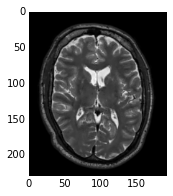

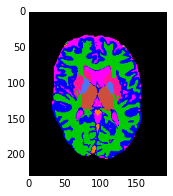

In [3]:
#myshow(DWI_img)
myshow(T2)
myshow(sitk.LabelToRGB(labelsMap))

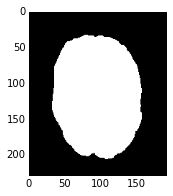

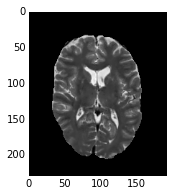

In [4]:
label_mask = labelsMap>0
myshow(label_mask)

# T2 with skull
T2_brain = sitk.Cast(T2,sitk.sitkFloat32) * sitk.Cast(label_mask,sitk.sitkFloat32)
myshow(T2_brain)

In [5]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
PROGRAM_PATHS = '/scratch/BS/release/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from SEMTools import *

In [6]:
myExtracter = extractNrrdVectorIndex()
myExtracter.inputs.inputVolume = dwiScan
myExtracter.inputs.vectorIndex = 0
myExtracter.inputs.outputVolume = 'B0_Image.nrrd'
print(myExtracter.cmdline)
myExtracter.run()

INFO:interface:stdout 2015-01-05T18:05:24.959191:Input Image: /Shared/johnsonhj/TrackOn/Experiments/20140203_DWIProcessing/VISUALLY_INSPECTED/HDNI_001/249903245/249903245_20110719_30/249903245_249903245_20110719_30_DWI_CONCAT_QCed_INSPECTED.nrrd
INFO:interface:stdout 2015-01-05T18:05:24.959191:Output Image: B0_Image.nrrd
INFO:interface:stdout 2015-01-05T18:05:24.959191:Vector Index: 0
INFO:interface:stdout 2015-01-05T18:05:24.959191:Set Image Orientation: AsAcquired
INFO:interface:stdout 2015-01-05T18:05:24.959191:


 extractNrrdVectorIndex  --inputVolume /Shared/johnsonhj/TrackOn/Experiments/20140203_DWIProcessing/VISUALLY_INSPECTED/HDNI_001/249903245/249903245_20110719_30/249903245_249903245_20110719_30_DWI_CONCAT_QCed_INSPECTED.nrrd --outputVolume B0_Image.nrrd --vectorIndex 0


(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


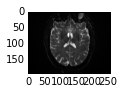

In [7]:
b0Image=sitk.ReadImage(myExtracter.inputs.outputVolume)
print(b0Image.GetDirection())
myshow(b0Image)

In [8]:
b0Image_2 = b0Image
print(b0Image_2.GetDirection())

b0Image_2.SetDirection([-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0])
print(b0Image_2.GetDirection())

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0)


In [9]:
#Tx = sitk.AffineTransform(3)
#Tx.SetMatrix(b0Image.GetDirection())
#print(Tx.GetMatrix())
#print(Tx.GetTranslation())
#sitk.WriteTransform(Tx,'rigidTransform.h5')

In [10]:
#from numpy import matrix

#Tx = sitk.VersorRigid3DTransform()
#paras=b0Image.GetDirection()
#m = matrix(paras)
#print(m)
#print(m.I)
#paras += (0.0,0.0,0.0)
#print(paras)
#Tx.SetParameters(paras)
#print(Tx.GetMatrix())

In [11]:
#b0Image.SetDirection([1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0])
#print(b0Image.GetDirection())

In [12]:
tx = sitk.CenteredVersorTransformInitializer(b0Image, b0Image_2, sitk.VersorRigid3DTransform(),computeRotation=True)

In [13]:
print(tx)

VersorRigid3DTransform (0x7f936e427310)
  RTTI typeinfo:   itk::VersorRigid3DTransform<double>
  Reference Count: 2
  Modified Time: 2205
  Debug: Off
  Object Name: 
  Observers: 
    none
  Matrix: 
    1 -2.63678e-16 1.94289e-16 
    -4.16334e-17 1 1.07553e-16 
    2.22045e-16 -6.93889e-17 1 
  Offset: [-2.5692e-14, 9.86628e-14, 9.9476e-14]
  Center: [-256.39, -189.225, -124.569]
  Translation: [0, 0, 0]
  Inverse: 
    1 2.77556e-16 -2.22045e-16 
    1.11022e-16 1 -2.77556e-17 
    -3.33067e-16 8.32667e-17 1 
  Singular: 0
  Versor: [ -4.42354e-17, -6.93889e-18, 5.55112e-17, 1 ]



In [14]:
def ForceDCtoID(inputVolume):
    inImage = sitk.ReadImage(inputVolume)
    inImage.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
    IDDCVolume = os.path.realpath('IDDC_'+ os.path.basename(inputVolume))
    return IDDCVolume

In [15]:
print(ForceDCtoID(t2Scan))

/Volumes/scratch/Notebooks/SimpleITK-Notebook-Answers/IDDC_t2_average_BRAINSABC.nii.gz


In [18]:
bfitRigidTx = sitk.ReadTransform('/scratch/TESTS/IpythonNotebook/1_DWI_Nipype_workflow/DWIPrototype_only1Subject/BFit_T2toB0/T2ToB0_RigidTransform.mat')
print(bfitRigidTx)

vrigid = sitk.VersorRigid3DTransform()
vrigid.SetFixedParameters(bfitRigidTx.GetFixedParameters())
vrigid.SetParameters(bfitRigidTx.GetParameters())
print(vrigid)

RuntimeError: Exception thrown in SimpleITK ReadTransform: /scratch/dashboards/OSX10.9-clang-6.0-pkg-py2.7/SimpleITK-build/ITK/Modules/IO/TransformMatlab/include/itkMatlabTransformIO.hxx:94:
itk::ERROR: MatlabTransformIOTemplate(0x7f936b41af20): The file could not be opened for read access 
Filename: "/scratch/TESTS/IpythonNotebook/1_DWI_Nipype_workflow/DWIPrototype_only1Subject/BFit_T2toB0/T2ToB0_RigidTransform.mat"

In [ ]:
def GetTransfromInverse(inputTransform):
    import SimpleITK as sitk
    inverseTransform = sitk.Transform(inputTransform)
    inverseTransform.SetInverse()
    #inverseTransform = inputTransform.GetInverse()
    return inverseTransform


In [17]:
invTx = GetTransfromInverse(vrigid)
print(invTx)
InvVersorRigid = sitk.VersorRigid3DTransform()
InvVersorRigid.SetFixedParameters(invTx.GetFixedParameters())
InvVersorRigid.SetParameters(invTx.GetParameters())
print(InvVersorRigid)

NameError: name 'GetTransfromInverse' is not defined

In [50]:
dwiScan1='/Shared/johnsonhj/TrackOn/Experiments/20140203_DWIProcessing/VISUALLY_INSPECTED/HDNI_001/249903245/249903245_20110719_30/249903245_249903245_20110719_30_DWI_CONCAT_QCed_INSPECTED.nrrd'
dwiScan2='/Shared/johnsonhj/TrackOn/Experiments/20140203_DWIProcessing/VISUALLY_INSPECTED/HDNI_004/866458223/866458223_20120920_30/866458223_866458223_20120920_30_DWI_CONCAT_QCed_INSPECTED.nrrd'
dwiScan3='/Shared/johnsonhj/TrackOn/Experiments/20140203_DWIProcessing/VISUALLY_INSPECTED/HDNI_003/823955340/823955340_20080609_30/823955340_823955340_20080609_30_DWI_CONCAT_QCed_INSPECTED.nrrd'

DWI1 = sitk.ReadImage(dwiScan1)
DWI2 = sitk.ReadImage(dwiScan2)
DWI3 = sitk.ReadImage(dwiScan3)

print(DWI1.GetDirection())
print(DWI2.GetDirection())
print(DWI3.GetDirection())

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(0.9995715721169656, -0.02438591252610002, -0.01618639817521977, 0.024236704299960124, 0.9996625118343209, -0.009351181624441226, 0.016408972554500093, 0.008954870371240008, 0.9998252626916065)


In [49]:
print(DWI2)

VectorImage (0x7fa30674b6e0)
  RTTI typeinfo:   itk::VectorImage<unsigned short, 3u>
  Reference Count: 1
  Modified Time: 3393
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 3236
  UpdateMTime: 3392
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [112, 112, 75]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [112, 112, 75]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [112, 112, 75]
  Spacing: [1.96429, 1.96429, 2]
  Origin: [-106.656, -117.107, -67.311]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
1.96429 0 0
0 1.96429 0
0 0 2

  PointToIndexMatrix: 
0.509091 0 0
0 0.509091 0
0 0 0.5

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  VectorLength: 37
  PixelContainer: 
    ImportImageContainer (0x7fa30670b340)
      RTTI typeinfo:   itk::ImportImageCo

In [2]:
DWIVolume = '/Shared/johnsonhj/TrackOn/Experiments/20140203_DWIProcessing/VISUALLY_INSPECTED/HDNI_003/823955340/823955340_20080609_30/823955340_823955340_20080609_30_DWI_CONCAT_QCed_INSPECTED.nrrd'

In [3]:
print(os.path.basename(DWIVolume))

823955340_823955340_20080609_30_DWI_CONCAT_QCed_INSPECTED.nrrd


In [4]:
print(os.path.dirname(DWIVolume))

/Shared/johnsonhj/TrackOn/Experiments/20140203_DWIProcessing/VISUALLY_INSPECTED/HDNI_003/823955340/823955340_20080609_30


In [5]:
sessionID=os.path.basename(os.path.dirname(DWIVolume))
print(sessionID)

823955340_20080609_30


In [6]:
subjectID=os.path.basename(os.path.dirname(os.path.dirname(DWIVolume)))
print(subjectID)

823955340


In [7]:
siteID=os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(DWIVolume))))
print(siteID)

HDNI_003


In [8]:
scalarsDIR = os.path.join('/Shared/sinapse/CACHE/20141124_TrackOn_base_Results/',
                              siteID,
                              subjectID,
                              sessionID,
                              'TissueClassify')
print(scalarsDIR)

/Shared/sinapse/CACHE/20141124_TrackOn_base_Results/HDNI_003/823955340/823955340_20080609_30/TissueClassify


In [9]:
T2_scan = os.path.join(scalarsDIR,'t2_average_BRAINSABC.nii.gz')
labelMap_image = os.path.join(scalarsDIR,'complete_brainlabels_seg.nii.gz')

In [10]:
print(T2_scan)

/Shared/sinapse/CACHE/20141124_TrackOn_base_Results/HDNI_003/823955340/823955340_20080609_30/TissueClassify/t2_average_BRAINSABC.nii.gz


In [11]:
print(labelMap_image)

/Shared/sinapse/CACHE/20141124_TrackOn_base_Results/HDNI_003/823955340/823955340_20080609_30/TissueClassify/complete_brainlabels_seg.nii.gz


In [14]:
WFname = 'DWIWorkflow_' + sessionID

In [15]:
print(WFname)

DWIWorkflow_823955340_20080609_30
